In [102]:
import os
total_images = 0
base_dir = r"/Users/fatimatuzzahra/Downloads/ADNI_coronal_sorted_5"

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.lower().endswith('.png'):
            total_images += 1

print("Total images in testing folder:", total_images)


Total images in testing folder: 840


In [103]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import torch
import clip
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [104]:
base_dir = r"/Users/fatimatuzzahra/Downloads/ADNI_coronal_sorted_5"
class_names = ['AD', 'CN', 'MCI']
total_images = 0

for class_name in class_names:
    path = os.path.join(base_dir, class_name)
    if os.path.exists(path):
        num_files = len([f for f in os.listdir(path) if f.lower().endswith('.png')])
        print(f"{class_name} coronal images: {num_files}")
        total_images += num_files
    else:
        print(f" Path not found: {path}")

print("Total coronal images:", total_images)


AD coronal images: 225
CN coronal images: 300
MCI coronal images: 315
Total coronal images: 840


In [109]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

# ==== CONFIG ====
base_dir = r"/Users/fatimatuzzahra/Downloads/ADNI_coronal_sorted_5"
classes = ['AD', 'CN', 'MCI']
test_size = 0.15
val_size = 0.15
random_state = 42

# ==== COLLECT SUBJECTS & FILE PATHS ====
subject_to_files = {}
subject_to_label = {}

for cls in classes:
    class_dir = os.path.join(base_dir, cls)
    if not os.path.exists(class_dir):
        print(f"Directory not found: {class_dir}")
        continue
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(".png"):
            # Extract subject ID (adjust split logic depending on filename pattern)
            # Example: "ADNI_12345_something.png" → subject_id = "12345"
            subject_id = fname.split("_")[0]  # Change this depending on your naming

            path = os.path.join(class_dir, fname)
            subject_to_files.setdefault(subject_id, []).append(path)
            subject_to_label[subject_id] = cls

# Map class names to numeric labels
label_map = {cls: idx for idx, cls in enumerate(classes)}
subject_ids = list(subject_to_files.keys())
subject_labels = [label_map[subject_to_label[sid]] for sid in subject_ids]

# ==== SUBJECT-WISE SPLIT ====
# Step 1: Train+Val vs Test
sub_train_val, sub_test, y_train_val, y_test = train_test_split(
    subject_ids, subject_labels,
    test_size=test_size,
    stratify=subject_labels,
    random_state=random_state
)

# Step 2: Train vs Val
val_relative_size = val_size / (1 - test_size)
sub_train, sub_val, y_train, y_val = train_test_split(
    sub_train_val, y_train_val,
    test_size=val_relative_size,
    stratify=y_train_val,
    random_state=random_state
)

# ==== EXPAND SUBJECT SPLITS TO IMAGE LISTS ====
def expand_subjects(sub_ids):
    paths = []
    labels = []
    for sid in sub_ids:
        paths.extend(subject_to_files[sid])
        labels.extend([label_map[subject_to_label[sid]]] * len(subject_to_files[sid]))
    return np.array(paths), np.array(labels)

X_train, y_train = expand_subjects(sub_train)
X_val, y_val = expand_subjects(sub_val)
X_test, y_test = expand_subjects(sub_test)

# ==== SAVE SPLITS ====
np.save("train_paths.npy", X_train)
np.save("train_labels.npy", y_train)
np.save("val_paths.npy", X_val)
np.save("val_labels.npy", y_val)
np.save("test_paths.npy", X_test)
np.save("test_labels.npy", y_test)

# ==== PRINT RESULTS ====
print("Split complete (subject-wise):")
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
print(f"Subjects - Train: {len(sub_train)}, Val: {len(sub_val)}, Test: {len(sub_test)}")

# Per-class distribution for each split
for split_name, labels in zip(["Train", "Val", "Test"], [y_train, y_val, y_test]):
    counts = np.bincount(labels, minlength=len(classes))
    print(f"{split_name} class distribution:")
    for cls_name, count in zip(classes, counts):
        print(f"  {cls_name}: {count}")

Split complete (subject-wise):
Train: 570, Val: 135, Test: 135
Subjects - Train: 38, Val: 9, Test: 9
Train class distribution:
  AD: 150
  CN: 210
  MCI: 210
Val class distribution:
  AD: 30
  CN: 45
  MCI: 60
Test class distribution:
  AD: 45
  CN: 45
  MCI: 45


In [132]:
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
from monai.transforms import ToTensor
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
import torchvision.transforms as T
from monai.networks.nets import DenseNet121
from monai.transforms import Compose, LoadImage, Resize, ScaleIntensity, EnsureChannelFirst
import torch

# ===== Load training split =====
train_paths = np.load("train_paths.npy", allow_pickle=True)
train_labels = np.load("train_labels.npy", allow_pickle=True)

# Extracting CLIP Image features
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model, preprocess_clip = clip.load("ViT-B/32", device=device)

# Define your own compatible augmentations
# augmenter = T.Compose([
#     T.Resize(224),
#     T.RandomHorizontalFlip(p=0.5),
#     T.RandomRotation(10),
#     T.GaussianBlur(kernel_size=3),
#     T.ToTensor(),
#     T.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))  # CLIP normalization
# ])

# EfficientNet base model
# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
# # Step 3: Build feature extractor model (outputs 256-dim feature vectors)
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x)
# x = Dense(256, activation='relu')(x)
# feature_extractor = Model(inputs=base_model.input, outputs=x)

# MONAI DenseNet model (pretrained on ImageNet)
# model = DenseNet121(spatial_dims=2, in_channels=3, out_channels=1000, pretrained=True)
# model.class_layers = torch.nn.Identity()  # remove classification head → gives feature vector
# model.to(device)
# model.eval()

# # MONAI transforms for preprocessing
# transform = Compose([
#     lambda p: Image.open(p).convert("RGB"),  # load as PIL
#     EnsureChannelFirst(),
#     Resize((224, 224)),
#     ScaleIntensity()
# ])

features, labels, image_paths = [], [], []
skipped_images = []



# Loop through training images for CLIP
for img_path, label in tqdm(zip(train_paths, train_labels), total=len(train_paths), desc="Processing Train Images"):
    try:
        pil_img = Image.open(img_path).convert("RGB")
        img_tensor = preprocess_clip(pil_img).unsqueeze(0).to(device)

        with torch.no_grad():
            feat = model.encode_image(img_tensor).cpu().numpy().flatten()

        features.append(feat)
        labels.append(label)
        image_paths.append(img_path)

    except Exception as e:
        print(f"Failed to process {img_path}: {e}")
        skipped_images.append(img_path)

# Loop through training images for EfficientNetB0
# for img_path, label in tqdm(zip(train_paths, train_labels), total=len(train_paths), desc="Processing Train Images"):
#     try:
#         img = Image.open(img_path).convert("RGB").resize((224, 224))
#         img_array = np.array(img)
#         img_array = np.expand_dims(img_array, axis=0)  # Add batch dim
#         img_array = preprocess_input(img_array)

#         feat = feature_extractor.predict(img_array, verbose=0).flatten()

#         features.append(feat)
#         labels.append(label)
#         image_paths.append(img_path)

#     except Exception as e:
#         print(f"Failed to process {img_path}: {e}")
#         skipped_images.append(img_path)

# Loop through training images for monai
# for img_path, label in tqdm(zip(train_paths, train_labels), total=len(train_paths), desc="Processing Train Images"):
#     try:
#         img = transform(img_path)  # MONAI pipeline
#         img = img.unsqueeze(0).to(device)  # add batch dim

#         with torch.no_grad():
#             feat = model(img).cpu().numpy().flatten()

#         features.append(feat)
#         labels.append(label)
#         image_paths.append(img_path)

#     except Exception as e:
#         print(f"Failed to process {img_path}: {e}")
#         skipped_images.append(img_path)

# Save results
features = np.array(features)
labels = np.array(labels)
image_paths = np.array(image_paths)

np.save("train_features_coronal.npy", features)
np.save("train_labels_coronal.npy", labels)
np.save("train_image_paths_coronal.npy", image_paths)

print(f" Features saved. Total processed: {len(features)} (expected: {len(train_paths) })")
print(f" Skipped images: {len(skipped_images)}")

Processing Train Images: 100%|██████████| 570/570 [00:12<00:00, 44.07it/s]

 Features saved. Total processed: 570 (expected: 570)
 Skipped images: 0


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


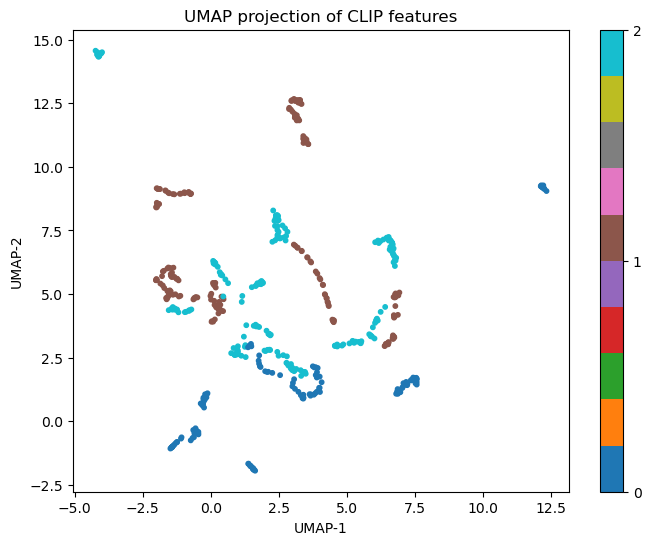

In [133]:
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import StandardScaler

# Load features and labels
features = np.load("train_features_coronal.npy")
labels = np.load("train_labels_coronal.npy")

# Optional: scale features (UMAP often works better after scaling)
features_scaled = StandardScaler().fit_transform(features)

# Initialize and fit UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(features_scaled)  # shape: (n_samples, 2)

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab10', s=10)
plt.colorbar(scatter, ticks=range(len(np.unique(labels))))
plt.title("UMAP projection of CLIP features")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

same process as above for validation data

In [135]:
import os
import numpy as np
from tqdm import tqdm
import imgaug.augmenters as iaa
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
# from tensorflow.keras.applications import DenseNet121.  # densenet code
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
import torchvision.transforms as T

# ===== Load training split =====
train_paths = np.load("val_paths.npy", allow_pickle=True)
train_labels = np.load("val_labels.npy", allow_pickle=True)

# Extracting CLIP Image features
model, preprocess_clip = clip.load("ViT-B/32", device=device)

# Define your own compatible augmentations
# augmenter = T.Compose([
#     T.Resize(224),
#     T.RandomHorizontalFlip(p=0.5),
#     T.RandomRotation(10),
#     T.GaussianBlur(kernel_size=3),
#     T.ToTensor(),
#     T.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))  # CLIP normalization
# ])


# EfficientNet ase model
# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
# # Step 3: Build feature extractor model (outputs 256-dim feature vectors)
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x)
# x = Dense(256, activation='relu')(x)
# feature_extractor = Model(inputs=base_model.input, outputs=x)




features, labels, image_paths = [], [], []
skipped_images = []

# Loop through training images
for img_path, label in tqdm(zip(train_paths, train_labels), total=len(train_paths), desc="Processing Train Images"):
    try:
        pil_img = Image.open(img_path).convert("RGB")
        img_tensor = preprocess_clip(pil_img).unsqueeze(0).to(device)

        with torch.no_grad():
            feat = model.encode_image(img_tensor).cpu().numpy().flatten()

        features.append(feat)
        labels.append(label)
        image_paths.append(img_path)

    except Exception as e:
        print(f"Failed to process {img_path}: {e}")
        skipped_images.append(img_path)

# Save results
features = np.array(features)
labels = np.array(labels)
image_paths = np.array(image_paths)

np.save("val_features_coronal.npy", features)
np.save("val_labels_coronal.npy", labels)
np.save("val_image_paths_coronal.npy", image_paths)

print(f" Features saved. Total processed: {len(features)} (expected: {len(train_paths) })")
print(f" Skipped images: {len(skipped_images)}")

Processing Train Images: 100%|██████████| 135/135 [00:02<00:00, 51.73it/s]

 Features saved. Total processed: 135 (expected: 135)
 Skipped images: 0


In [136]:
import os
import numpy as np
from tqdm import tqdm
import torch
import clip
from PIL import Image

# ===== Load testing split =====
test_paths = np.load("test_paths.npy", allow_pickle=True)
test_labels = np.load("test_labels.npy", allow_pickle=True)

# Load CLIP model (ViT-B/32)
device = "mps" if torch.cuda.is_available() else "cpu"
model, preprocess_clip = clip.load("ViT-B/32", device=device)

features, labels, image_paths = [], [], []
skipped_images = []

# Loop through test images (no augmentation)
for img_path, label in tqdm(zip(test_paths, test_labels), total=len(test_paths), desc="Processing Test Images"):
    try:
        pil_img = Image.open(img_path).convert("RGB")

        # Preprocess for CLIP
        img_tensor = preprocess_clip(pil_img).unsqueeze(0).to(device)

        # Extract features
        with torch.no_grad():
            feat = model.encode_image(img_tensor).cpu().numpy().flatten()

        features.append(feat)
        labels.append(label)
        image_paths.append(img_path)

    except Exception as e:
        print(f"Failed to process {img_path}: {e}")
        skipped_images.append(img_path)

# Save results
features = np.array(features)
labels = np.array(labels)
image_paths = np.array(image_paths)

np.save("test_features_coronal.npy", features)
np.save("test_labels_coronal.npy", labels)
np.save("test_image_paths_coronal.npy", image_paths)

print(f" Test features saved. Total processed: {len(features)} / {len(test_paths)}")
print(f" Skipped images: {len(skipped_images)}")

Processing Test Images: 100%|██████████| 135/135 [00:05<00:00, 23.12it/s]

 Test features saved. Total processed: 135 / 135
 Skipped images: 0


In [137]:
features = np.load("train_features_coronal.npy")       # Shape: (525, 512)
print(features.shape)
labels = np.load("train_labels_coronal.npy")           # Shape: (525,)
print(labels.shape)
image_paths = np.load("train_image_paths_coronal.npy") # Shape: (525,)
print(image_paths.shape)


(570, 512)
(570,)
(570,)


In [138]:
features = np.load("val_features_coronal.npy")       # Shape: (127, 512))
print(features.shape)
labels = np.load("val_labels_coronal.npy")           # Shape: (127,)
print(labels.shape)
image_paths = np.load("val_image_paths_coronal.npy") # Shape: (127,)
print(image_paths.shape)


(135, 512)
(135,)
(135,)


In [139]:
features = np.load("test_features_coronal.npy")       # Shape: (126, 512)
print(features.shape)
labels = np.load("test_labels_coronal.npy")           # Shape: (126,)
print(labels.shape)
image_paths = np.load("test_image_paths_coronal.npy") # Shape: (126,)
print(image_paths.shape)


(135, 512)
(135,)
(135,)


In [140]:
# Load the .npy files
import pandas as pd
features = np.load("train_features_coronal.npy")       # Shape: (84755, 256)
labels = np.load("train_labels_coronal.npy")           # Shape: (84755,)

# Combine features and labels
combined = np.hstack((features, labels.reshape(-1, 1)))  # Shape: (84755, 257)

# Create a DataFrame
df = pd.DataFrame(combined)

# Optionally name columns

feature_columns = [f"f{i}" for i in range(features.shape[1])]
df.columns = feature_columns + ["label"]

# Save to CSV
df.to_csv("train_coronal_features_and_labels_only.csv", index=False)

print(" Saved: train_coronal_features_and_labels_only.csv")


 Saved: train_coronal_features_and_labels_only.csv


same process for validation set

In [ ]:
# Load the .npy files
features = np.load("val_features_coronal.npy")       # Shape: (135, 512)
labels = np.load("val_labels_coronal.npy")           # Shape: (135,)

# Combine features and labels
combined = np.hstack((features, labels.reshape(-1, 1)))  # Shape: (135, 513)

# Create a DataFrame
df = pd.DataFrame(combined)

# Optionally name columns
feature_columns = [f"f{i}" for i in range(features.shape[1])]
df.columns = feature_columns + ["label"]

# Save to CSV
df.to_csv("val_coronal_features_and_labels_only.csv", index=False)

print(" Saved: val_coronal_features_and_labels_only.csv")


 Saved: val_coronal_features_and_labels_only.csv


In [ ]:
# Load the .npy files
features = np.load("test_features_coronal.npy")       # Shape: (135, 512)
labels = np.load("test_labels_coronal.npy")           # Shape: (135, )

# Combine features and labels
combined = np.hstack((features, labels.reshape(-1, 1)))  # Shape: (135, 513)

# Create a DataFrame
df = pd.DataFrame(combined)

# Optionally name columns
feature_columns = [f"f{i}" for i in range(features.shape[1])]
df.columns = feature_columns + ["label"]

# Save to CSV
df.to_csv("test_coronal_features_and_labels_only.csv", index=False)

print(" Saved: test_coronal_features_and_labels_only.csv")


 Saved: test_coronal_features_and_labels_only.csv


In [163]:
text_embeddings = np.load("text_embeddings_cleaned.npy")  # (N_text, dim_text)
text_ids = np.load("text_image_ids.npy", allow_pickle=True)

# Build lookup
text_lookup = {tid: emb for tid, emb in zip(text_ids, text_embeddings)}

def get_text_features_for_split(image_paths, image_labels):
    feats, labels = [], []
    for path, label in zip(image_paths, image_labels):
        sid = os.path.basename(path).split('_')[0]
        if sid in text_lookup:
            feats.append(text_lookup[sid])
            labels.append(label)
    return np.array(feats), np.array(labels)

# Train text features
train_paths = np.load("train_image_paths_coronal.npy", allow_pickle=True)
train_labels = np.load("train_labels_coronal.npy", allow_pickle=True)
train_text_feats, train_text_labels = get_text_features_for_split(train_paths, train_labels)
np.save("train_text_features.npy", train_text_feats)
np.save("train_text_labels.npy", train_text_labels)
print("Saved: train_text_features.npy", train_text_feats.shape)
print("train_text_labels.npy", train_text_labels.shape)

Saved: train_text_features.npy (570, 512)
train_text_labels.npy (570,)


In [153]:
text_embeddings = np.load("text_embeddings_cleaned.npy")  # (N_text, dim_text)
text_ids = np.load("text_image_ids.npy", allow_pickle=True)

# Build lookup
text_lookup = {tid: emb for tid, emb in zip(text_ids, text_embeddings)}

def get_text_features_for_split(image_paths, image_labels):
    feats, labels = [], []
    for path, label in zip(image_paths, image_labels):
        sid = os.path.basename(path).split('_')[0]
        if sid in text_lookup:
            feats.append(text_lookup[sid])
            labels.append(label)
    return np.array(feats), np.array(labels)

# val text features
val_paths = np.load("val_image_paths_coronal.npy", allow_pickle=True)
val_labels = np.load("val_labels_coronal.npy", allow_pickle=True)
val_text_feats, val_text_labels = get_text_features_for_split(val_paths, val_labels)
np.save("val_text_features.npy", val_text_feats)
np.save("val_text_labels.npy", val_text_labels)

In [148]:
text_embeddings = np.load("text_embeddings_cleaned.npy")  # (N_text, dim_text)
text_ids = np.load("text_image_ids.npy", allow_pickle=True)

# Build lookup
text_lookup = {tid: emb for tid, emb in zip(text_ids, text_embeddings)}

def get_text_features_for_split(image_paths, image_labels):
    feats, labels = [], []
    for path, label in zip(image_paths, image_labels):
        sid = os.path.basename(path).split('_')[0]
        if sid in text_lookup:
            feats.append(text_lookup[sid])
            labels.append(label)
    return np.array(feats), np.array(labels)

# test text features
test_paths = np.load("test_image_paths_coronal.npy", allow_pickle=True)
test_labels = np.load("test_labels_coronal.npy", allow_pickle=True)
test_text_feats, test_text_labels = get_text_features_for_split(test_paths, test_labels)
np.save("test_text_features.npy", test_text_feats)
np.save("test_text_labels.npy", test_text_labels)

In [157]:
def fuse_features(image_features, image_paths, text_lookup):
    fused = []
    for feat, path in zip(image_features, image_paths):
        sid = os.path.basename(path).split('_')[0]
        if sid in text_lookup:
            fused.append(np.concatenate([feat, text_lookup[sid]]))
    return np.array(fused)

# Build text lookup from train_text_features
train_paths = np.load("train_image_paths_coronal.npy", allow_pickle=True)
train_labels = np.load("train_labels_coronal.npy", allow_pickle=True)

train_text_feats = np.load("train_text_features.npy")
train_text_lookup = {os.path.basename(p).split('_')[0]: feat 
                     for p, feat in zip(train_paths, train_text_feats)}

# Fuse train
train_mri_feats = np.load("train_features_coronal.npy")
train_fused_feats = fuse_features(train_mri_feats, train_paths, train_text_lookup)

# Save fused features and labels
np.save("train_fused_features.npy", train_fused_feats)
np.save("train_fused_labels.npy", train_labels)

print("Saved: train_fused_features.npy", train_fused_feats.shape)
print("Saved: train_fused_labels.npy", train_labels.shape)

Saved: train_fused_features.npy (570, 1024)
Saved: train_fused_labels.npy (570,)


In [158]:
def fuse_features(image_features, image_paths, text_lookup):
    fused = []
    for feat, path in zip(image_features, image_paths):
        sid = os.path.basename(path).split('_')[0]
        if sid in text_lookup:
            fused.append(np.concatenate([feat, text_lookup[sid]]))
    return np.array(fused)

# Build text lookup from val_text_features
val_paths = np.load("val_image_paths_coronal.npy", allow_pickle=True)
val_labels = np.load("val_labels_coronal.npy", allow_pickle=True)

val_text_feats = np.load("val_text_features.npy")
val_text_lookup = {os.path.basename(p).split('_')[0]: feat 
                     for p, feat in zip(val_paths, val_text_feats)}

# Fuse val
val_mri_feats = np.load("val_features_coronal.npy")
val_fused_feats = fuse_features(val_mri_feats, val_paths, val_text_lookup)

# Save fused features and labels
np.save("val_fused_features.npy", val_fused_feats)
np.save("val_fused_labels.npy", val_labels)

print("Saved: val_fused_features.npy", val_fused_feats.shape)
print("Saved: val_fused_labels.npy", val_labels.shape)

Saved: val_fused_features.npy (135, 1024)
Saved: val_fused_labels.npy (135,)


In [159]:
def fuse_features(image_features, image_paths, text_lookup):
    fused = []
    for feat, path in zip(image_features, image_paths):
        sid = os.path.basename(path).split('_')[0]
        if sid in text_lookup:
            fused.append(np.concatenate([feat, text_lookup[sid]]))
    return np.array(fused)

# Build text lookup from test_text_features
test_paths = np.load("test_image_paths_coronal.npy", allow_pickle=True)
test_labels = np.load("test_labels_coronal.npy", allow_pickle=True)

test_text_feats = np.load("test_text_features.npy")
test_text_lookup = {os.path.basename(p).split('_')[0]: feat 
                     for p, feat in zip(test_paths, test_text_feats)}

# Fuse test
test_mri_feats = np.load("test_features_coronal.npy")
test_fused_feats = fuse_features(test_mri_feats, test_paths, test_text_lookup)

# Save fused features and labels
np.save("test_fused_features.npy", test_fused_feats)
np.save("test_fused_labels.npy", test_labels)

print("Saved: test_fused_features.npy", test_fused_feats.shape)
print("Saved: test_fused_labels.npy", test_labels.shape)

Saved: test_fused_features.npy (135, 1024)
Saved: test_fused_labels.npy (135,)


import numpy as np
from tqdm import tqdm
import os

# Load image feature data
image_features = np.load("train_features_coronal.npy")       # (84755, 256)
image_labels = np.load("train_labels_coronal.npy")           # (84755,)
image_paths = np.load("train_image_paths_coronal.npy")       # (84755,)



# Step 2: Match each image with its text embedding (based on ID prefix)
fused_features = []
fused_labels = []
matched_count = 0

for i, (img_feat, label, path) in enumerate(tqdm(zip(image_features, image_labels, image_paths), total=len(image_paths))):
    filename = os.path.basename(path)  # e.g., 'I31143_AD_coronal_55.png'
    img_id = filename.split('_')[0]             # 'I31143'

    if img_id in text_lookup:
        text_feat = text_lookup[img_id]
        fused = np.concatenate([img_feat, text_feat])  # shape (640,)
        fused_features.append(fused)
        fused_labels.append(label)
        matched_count += 1

print(f" Matched samples: {matched_count}")

# Convert to arrays and save
fused_features = np.array(fused_features)
fused_labels = np.array(fused_labels)

np.save("train_fused_features_clean.npy", fused_features)
np.save("train_fused_labels_clean.npy", fused_labels)

print(" Final train fused shape:", fused_features.shape)
print(" Labels shape:", fused_labels.shape)


fusion for the validation set is done below

import numpy as np
from tqdm import tqdm
import os

# Load image feature data
image_features = np.load("val_features_coronal.npy")       # (84755, 256)
image_labels = np.load("val_labels_coronal.npy")           # (84755,)
image_paths = np.load("val_image_paths_coronal.npy")       # (84755,)

# Load cleaned textual embeddings and IDs
textual_embeddings = np.load("text_embeddings_cleaned.npy")   # (2294, 384)
text_ids = np.load("text_image_ids.npy", allow_pickle=True)      # (2294,)

# Step 1: Build a lookup from Image ID → text embedding
text_lookup = {id_: emb for id_, emb in zip(text_ids, textual_embeddings)}

# Step 2: Match each image with its text embedding (based on ID prefix)
fused_features = []
fused_labels = []
matched_count = 0

for i, (img_feat, label, path) in enumerate(tqdm(zip(image_features, image_labels, image_paths), total=len(image_paths))):
    filename = os.path.basename(path)  # e.g., 'I31143_AD_coronal_55.png'
    img_id = filename.split('_')[0]             # 'I31143'

    if img_id in text_lookup:
        text_feat = text_lookup[img_id]
        fused = np.concatenate([img_feat, text_feat])  # shape (640,)
        fused_features.append(fused)
        fused_labels.append(label)
        matched_count += 1

print(f" Matched samples: {matched_count}")

# Convert to arrays and save
fused_features = np.array(fused_features)
fused_labels = np.array(fused_labels)

np.save("val_fused_features_clean.npy", fused_features)
np.save("val_fused_labels_clean.npy", fused_labels)

print(" Final val fused shape:", fused_features.shape)
print(" Labels shape:", fused_labels.shape)


import numpy as np
from tqdm import tqdm
import os

# Load image feature data
image_features = np.load("test_features_coronal.npy")       # (84755, 256)
image_labels = np.load("test_labels_coronal.npy")           # (84755,)
image_paths = np.load("test_image_paths_coronal.npy")       # (84755,)

# Load cleaned textual embeddings and IDs
textual_embeddings = np.load("text_embeddings_cleaned.npy")   # (2294, 384)
text_ids = np.load("text_image_ids.npy", allow_pickle=True)      # (2294,)

# Step 1: Build a lookup from Image ID → text embedding
text_lookup = {id_: emb for id_, emb in zip(text_ids, textual_embeddings)}

# Step 2: Match each image with its text embedding (based on ID prefix)
fused_features = []
fused_labels = []
matched_count = 0

for i, (img_feat, label, path) in enumerate(tqdm(zip(image_features, image_labels, image_paths), total=len(image_paths))):
    filename = os.path.basename(path)  # e.g., 'I31143_AD_coronal_55.png'
    img_id = filename.split('_')[0]             # 'I31143'

    if img_id in text_lookup:
        text_feat = text_lookup[img_id]
        fused = np.concatenate([img_feat, text_feat])  # shape (640,)
        fused_features.append(fused)
        fused_labels.append(label)
        matched_count += 1

print(f" Matched samples: {matched_count}")

# Convert to arrays and save
fused_features = np.array(fused_features)
fused_labels = np.array(fused_labels)

np.save("test_fused_features_clean.npy", fused_features)
np.save("test_fused_labels_clean.npy", fused_labels)

print(" Final test fused shape:", fused_features.shape)
print(" Labels shape:", fused_labels.shape)


In [160]:
import numpy as np
import pandas as pd

# Load
X = np.load("train_fused_features.npy")
y = np.load("train_fused_labels.npy")

# Combine into DataFrame
df = pd.DataFrame(X)
df["label"] = y

# Save to CSV
df.to_csv("train_fused_embeddings_with_labels.csv", index=False)
print(" Saved: train_fused_embeddings_with_labels.csv")


 Saved: train_fused_embeddings_with_labels.csv


savinf into csv the validation fused sets

In [161]:
import numpy as np
import pandas as pd

# Load
X = np.load("val_fused_features_clean.npy")
y = np.load("val_fused_labels_clean.npy")

# Combine into DataFrame
df = pd.DataFrame(X)
df["label"] = y

# Save to CSV
df.to_csv("val_fused_embeddings_with_labels.csv", index=False)
print(" Saved: val_fused_embeddings_with_labels.csv")


 Saved: val_fused_embeddings_with_labels.csv


In [162]:
import numpy as np
import pandas as pd

# Load
X = np.load("test_fused_features_clean.npy")
y = np.load("test_fused_labels_clean.npy")

# Combine into DataFrame
df = pd.DataFrame(X)
df["label"] = y

# Save to CSV
df.to_csv("test_fused_embeddings_with_labels.csv", index=False)
print(" Saved: test_fused_embeddings_with_labels.csv")


 Saved: test_fused_embeddings_with_labels.csv


saving image and textual data separately for training dataset

In [77]:
import numpy as np

# Load fused embeddings
fused = np.load("train_fused_features_clean.npy")  # (84755, 640)

# Split features
image_features = fused[:, :512]   # CNN-based
text_features  = fused[:, 512:]   # Sentence-transformer-based

# Save separately
np.save("train_image_features_only.npy", image_features)
np.save("train_text_features_only.npy", text_features)

print(" Saved:")
print("  train_image_features_only.npy (shape:", image_features.shape, ")")
print("  train_text_features_only.npy  (shape:", text_features.shape, ")")


 Saved:
  train_image_features_only.npy (shape: (587, 512) )
  train_text_features_only.npy  (shape: (587, 512) )


saving image and textual data separately for validation dataset

In [ ]:
import numpy as np

# Load fused embeddings
fused = np.load("val_fused_features_clean.npy")  # (127, 1024)

# Split features
image_features = fused[:, :512]   # CNN-based
text_features  = fused[:, 512:]   # Sentence-transformer-based

# Save separately
np.save("val_image_features_only.npy", image_features)
np.save("val_text_features_only.npy", text_features)

print(" Saved:")
print("  val_image_features_only.npy (shape:", image_features.shape, ")")
print("  val_text_features_only.npy  (shape:", text_features.shape, ")")


 Saved:
  val_image_features_only.npy (shape: (127, 512) )
  val_text_features_only.npy  (shape: (127, 512) )


In [ ]:
import numpy as np

# Load fused embeddings
fused = np.load("test_fused_features_clean.npy")  # (126, 1024)

# Split features
image_features = fused[:, :512]   # CNN-based
text_features  = fused[:, 512:]   # Sentence-transformer-based

# Save separately
np.save("test_image_features_only.npy", image_features)
np.save("test_text_features_only.npy", text_features)

print(" Saved:")
print("  test_image_features_only.npy (shape:", image_features.shape, ")")
print("  test_text_features_only.npy  (shape:", text_features.shape, ")")


 Saved:
  test_image_features_only.npy (shape: (126, 512) )
  test_text_features_only.npy  (shape: (126, 512) )


the code below is added just to save the progress

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 Step 1: Load training set fused features and labels
X_train = np.load("train_fused_features_clean.npy")   # Shape: (84755, 640)
y_train = np.load("train_fused_labels_clean.npy")     # Shape: (84755,)

# Step 2: Load validation set fused features and labels
X_val = np.load("val_fused_features_clean.npy")
y_val = np.load("val_fused_labels_clean.npy")

# 🔹 Step 2: Train/test split (not used for testing file)
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )

# 🔹 Step 3: Define and train MLP (no need of fitting again in test set)
mlp = MLPClassifier(
    hidden_layer_sizes=(512, 256, 64),   # You can adjust the architecture
    activation='relu',
    learning_rate_init=0.0006,
    solver='adam',
    max_iter=50,          # Increase to 100–300 for better results if time allows
    random_state=42,
    verbose=True
)
mlp.fit(X_train, y_train)

# 🔹 Step 4: Predict and evaluate
y_pred = mlp.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"\n MLP Accuracy: {acc:.4f}")
print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=["AD", "CN", "MCI"]))

# 🔹 Step 5: Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=["AD", "CN", "MCI"], yticklabels=["AD", "CN", "MCI"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(" Confusion Matrix - MLP (Fused Features)")
plt.tight_layout()
plt.show()


In [82]:
class MLPWithDropout(nn.Module):
    def __init__(self, input_dim):
        super(MLPWithDropout, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 3)
        )

    def forward(self, x):
        return self.net(x)



Epoch 1/100, Train Loss: 1.0955, Val Loss: 1.1339
Epoch 2/100, Train Loss: 1.0641, Val Loss: 1.1123
Epoch 3/100, Train Loss: 1.0335, Val Loss: 1.0918
Epoch 4/100, Train Loss: 1.0121, Val Loss: 1.0718
Epoch 5/100, Train Loss: 0.9839, Val Loss: 1.0520
Epoch 6/100, Train Loss: 0.9643, Val Loss: 1.0328
Epoch 7/100, Train Loss: 0.9339, Val Loss: 1.0120
Epoch 8/100, Train Loss: 0.9136, Val Loss: 0.9903
Epoch 9/100, Train Loss: 0.8836, Val Loss: 0.9666
Epoch 10/100, Train Loss: 0.8767, Val Loss: 0.9436
Epoch 11/100, Train Loss: 0.8459, Val Loss: 0.9196
Epoch 12/100, Train Loss: 0.8178, Val Loss: 0.8968
Epoch 13/100, Train Loss: 0.7900, Val Loss: 0.8735
Epoch 14/100, Train Loss: 0.7692, Val Loss: 0.8505
Epoch 15/100, Train Loss: 0.7464, Val Loss: 0.8278
Epoch 16/100, Train Loss: 0.7295, Val Loss: 0.8048
Epoch 17/100, Train Loss: 0.7009, Val Loss: 0.7817
Epoch 18/100, Train Loss: 0.6693, Val Loss: 0.7603
Epoch 19/100, Train Loss: 0.6425, Val Loss: 0.7404
Epoch 20/100, Train Loss: 0.6395, Val Lo

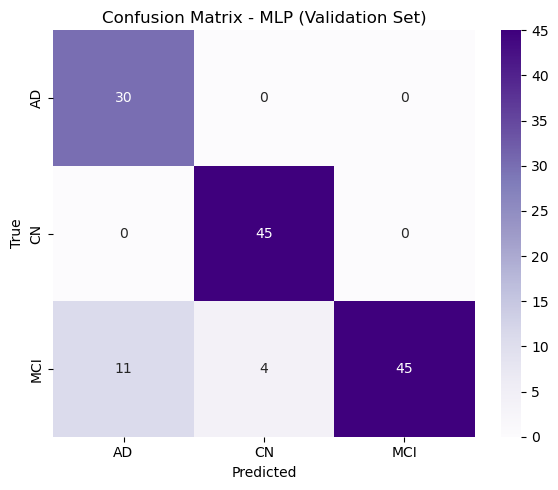

In [171]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import torch.nn as nn
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
import torch 
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# Load data
X_train = np.load("train_features_coronal.npy")
y_train = np.load("train_labels_coronal.npy")
X_val = np.load("val_features_coronal.npy")
y_val = np.load("val_labels_coronal.npy")

# y_train = np.where(y_train == 2, 1, 0)
# y_val = np.where(y_val == 2, 1, 0)

# Optional: if your MLP has 1024 input, pad image/text features accordingly
# assert X_train.shape[1] == 1024

# Scale inputs
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_bal, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_bal, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)



input_dim = X_train.shape[1]  # or manually set to 256 for image-only
model = MLPWithDropout(input_dim).to(device).to("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Early stop[ping variables
num_epochs = 100
patience = 5  # how many epochs to wait before early stopping

train_losses = []
val_losses = []

best_val_loss = float("inf")
early_stop_epoch = -1
epochs_no_improve = 0
best_model_state = None


for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)  # logits (batch, num_classes)
        loss = criterion(out, yb)  # labels are ints 0..2
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---------------- Validation and Early Stopping ----------------
    model.eval()
    val_loss = 0.0
    y_val_preds = []
    y_val_true = []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            val_loss += loss.item()
            preds = torch.argmax(out, dim=1)
            y_val_preds.extend(preds.cpu().numpy())
            y_val_true.extend(yb.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        early_stop_epoch = epoch
        best_model_state = model.state_dict()

    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            early_stop_epoch = epoch  # ⏹️ Where stopping actually happens
            print(f" Early stopping triggered at epoch {epoch+1}")
            break
# 🔹 Evaluate on Training Set
model.eval()
y_train_preds = []
y_train_true = []
with torch.no_grad():
    for xb, yb in train_loader:
        xb = xb.to(device)
        out = model(xb)
        preds = torch.argmax(out, dim=1)
        y_train_preds.extend(preds.cpu().numpy())
        y_train_true.extend(yb.numpy())

    # Training Metrics
    train_acc = accuracy_score(y_train_true, y_train_preds)
    print(f"📊 Training Accuracy: {train_acc:.4f}")

# Restore best model
model.load_state_dict(best_model_state)

# Final evaluation on validation set
val_acc = accuracy_score(y_val_true, y_val_preds)
print(f" Validation Accuracy: {val_acc:.4f}")
print("Classification Report:\n", classification_report(y_val_true, y_val_preds, target_names=["AD","CN", "MCI"]))

cm = confusion_matrix(y_val_true, y_val_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=["AD","CN", "MCI"], yticklabels=["AD","CN", "MCI"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - MLP (Validation Set)")
plt.tight_layout()
plt.show()

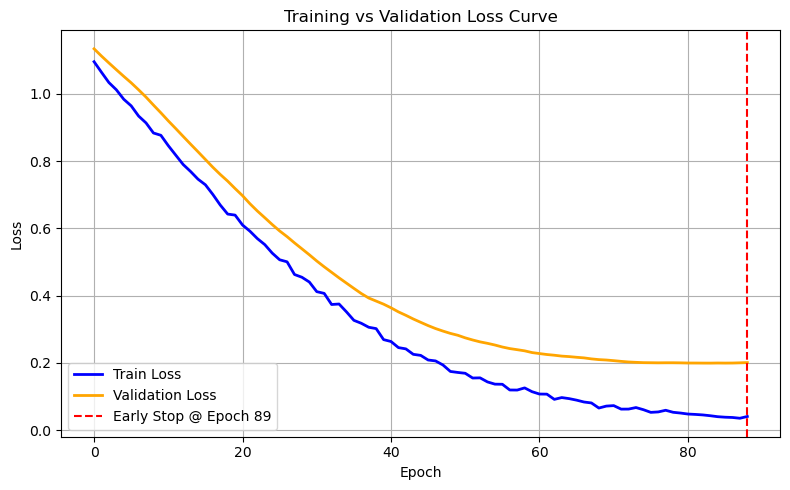

In [172]:
# 🔻 Loss Curve with Early Stopping Marker
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='orange', linewidth=2)

# Mark early stopping epoch
if early_stop_epoch != -1:
    plt.axvline(early_stop_epoch, color='red', linestyle='--', label=f"Early Stop @ Epoch {early_stop_epoch+1}")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [173]:
from sklearn.metrics import classification_report, accuracy_score

# Assuming y_test and y_pred are already defined from your previous evaluation

# Define class labels (you can update these if your label encoding is different)
class_names = ['AD', 'CN', 'MCI']

# Accuracy
accuracy = accuracy_score(y_val_true, y_val_preds)
print(f"\n Accuracy: {accuracy:.4f}")

# Precision, Recall, F1-score
print("\n Classification Report:")
print(classification_report(y_val_true, y_val_preds, target_names=class_names))



 Accuracy: 0.8889

 Classification Report:
              precision    recall  f1-score   support

          AD       0.73      1.00      0.85        30
          CN       0.92      1.00      0.96        45
         MCI       1.00      0.75      0.86        60

    accuracy                           0.89       135
   macro avg       0.88      0.92      0.89       135
weighted avg       0.91      0.89      0.89       135



🧪 Test Accuracy: 0.6148
Classification Report (Test Set):
               precision    recall  f1-score   support

          AD       0.85      0.38      0.52        45
          CN       0.61      0.91      0.73        45
         MCI       0.52      0.56      0.54        45

    accuracy                           0.61       135
   macro avg       0.66      0.61      0.60       135
weighted avg       0.66      0.61      0.60       135



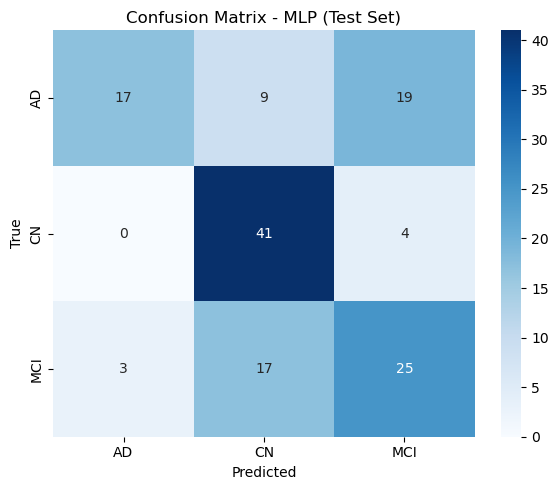

In [174]:
# -------------------- Load Test Data --------------------
X_test = np.load("test_features_coronal.npy")
y_test = np.load("test_labels_coronal.npy")

# Optional: same binary mapping as train/val if needed
# y_test = np.where(y_test == 2, 1, 0)

# Scale with the SAME scaler fitted on training data
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for test set
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# -------------------- Evaluate on Test Set --------------------
model.eval()  # put model in evaluation mode
y_test_preds = []
y_test_true = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)
        preds = torch.argmax(out, dim=1)
        y_test_preds.extend(preds.cpu().numpy())
        y_test_true.extend(yb.cpu().numpy())

# Test Accuracy
test_acc = accuracy_score(y_test_true, y_test_preds)
print(f"🧪 Test Accuracy: {test_acc:.4f}")

# Classification Report
print("Classification Report (Test Set):\n",
      classification_report(y_test_true, y_test_preds, target_names=["AD","CN","MCI"]))

# Confusion Matrix
cm_test = confusion_matrix(y_test_true, y_test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=["AD","CN","MCI"], yticklabels=["AD","CN","MCI"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - MLP (Test Set)")
plt.tight_layout()
plt.show()

VISUALISE THE RAW DATA FEATURES

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


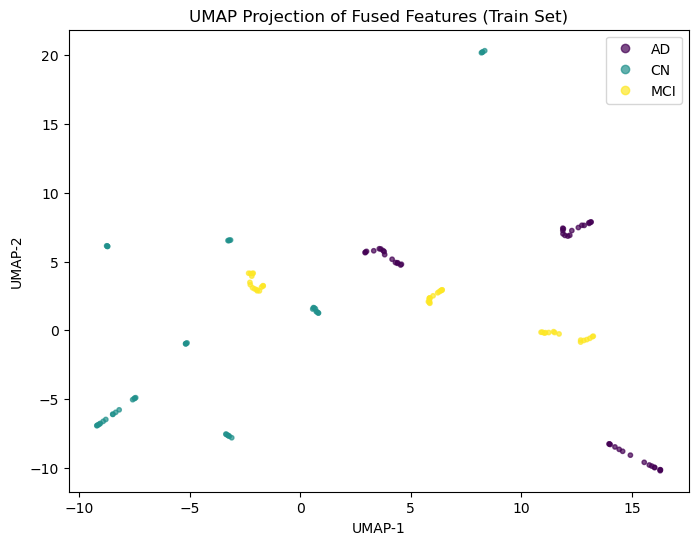

In [170]:
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler


# Load your features and labels (you can choose train/val/test)
X = np.load("test_features_coronal.npy")  # Shape: (samples, 640)
y = np.load("test_labels_coronal.npy")    # Shape: (samples,)

# X = StandardScaler().fit_transform(X)

# Initialize UMAP reducer
reducer = umap.UMAP(
    n_neighbors=4,   # controls local vs global structure
    min_dist=0.1,     # smaller = more clustered points
    n_components=3,   # 2D projection (set 3 for 3D)
    random_state=42
)

# Fit and transform
embedding = reducer.fit_transform(X)  # Shape: (samples, 2)

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=y, cmap='viridis', s=10, alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=["AD", "CN", "MCI"])
plt.title("UMAP Projection of Fused Features (Train Set)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


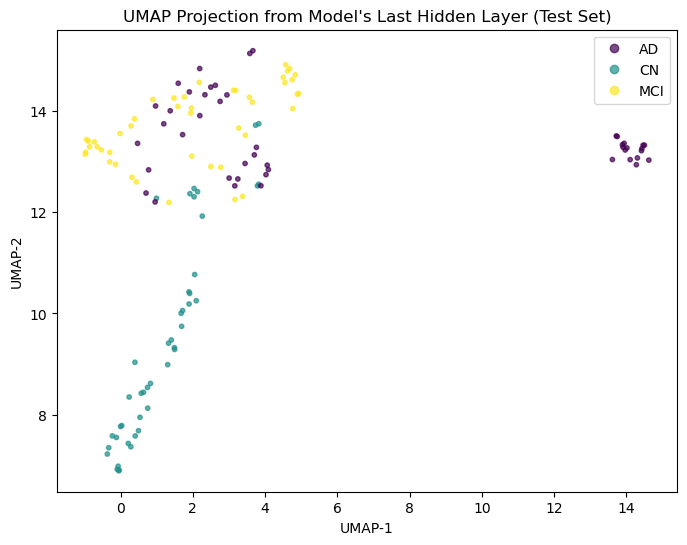

In [169]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import torch
import numpy as np

# Function to extract embeddings from the trained model
def get_embeddings(model, dataloader, device):
    model.eval()
    embeddings = []
    labels = []

    # Extract everything except the final classification layer
    feature_extractor = torch.nn.Sequential(*list(model.net.children())[:-1])

    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(device)
            feats = feature_extractor(xb)  # shape: (batch, 64)
            embeddings.append(feats.cpu().numpy())
            labels.append(yb.numpy())

    embeddings = np.vstack(embeddings)
    labels = np.hstack(labels)
    return embeddings, labels

# Get embeddings for your test set
test_embeddings, test_labels = get_embeddings(model, test_loader, device)

# Scale for UMAP
from sklearn.preprocessing import StandardScaler
scaled_embeds = StandardScaler().fit_transform(test_embeddings)

# UMAP projection to 2D
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_embeds = reducer.fit_transform(scaled_embeds)

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(umap_embeds[:, 0], umap_embeds[:, 1], c=test_labels, cmap='viridis', s=10, alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=["AD", "CN", "MCI"])
plt.title("UMAP Projection from Model's Last Hidden Layer (Test Set)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()